Inspired By:\
https://github.com/JRC1995/Bi-GRU-CRF-NER

https://www.kaggle.com/code/samarthsarin/keras-gru-with-glove-embedding/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tf2crf

In [ ]:
!pip install sklearn_crfsuite

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#CONLL data
class SentenceGetter(object):
    
    def __init__(self, filenames):
        self.sentences_map = {} #"train":[], valid
        self.filenames = filenames
        self.words = set()
        self.tags = set()
        niter = 0
        for filename in filenames:
          self.filename = filename
          self.sentences = []
          with open(self.filename) as f:
              sentence = []
              for line in f:
                  line = line.strip()
                  if (len(line) == 0 or line.startswith("-DOCSTART-")):
                      if len(sentence) != 0:
                        self.sentences.append(sentence)
                        sentence = []
                      continue
                  else:
                      ls = line.split(' ')
                      word, tag = ls[0],ls[3] #word - - tag
                      self.words.add(word)
                      self.tags.add(tag)
                      sentence.append((word,tag))
          if ("train" in filename):
            self.sentences_map["train"] = self.sentences
          elif ("valid" in filename):
            self.sentences_map["valid"] = self.sentences
          else:
            self.sentences_map["test"] = self.sentences

In [ ]:
files = ["/content/drive/MyDrive/MasterThesis/coNLL/train.txt", "/content/drive/MyDrive/MasterThesis/coNLL/valid.txt"] 

In [ ]:
#CONLL data
getter = SentenceGetter(files)
sentences_map = getter.sentences_map
words = getter.words
tags = list(getter.tags)

In [ ]:
sentences_map["valid"][1:3]

[[('LONDON', 'B-LOC'), ('1996-08-30', 'O')],
 [('West', 'B-MISC'),
  ('Indian', 'I-MISC'),
  ('all-rounder', 'O'),
  ('Phil', 'B-PER'),
  ('Simmons', 'I-PER'),
  ('took', 'O'),
  ('four', 'O'),
  ('for', 'O'),
  ('38', 'O'),
  ('on', 'O'),
  ('Friday', 'O'),
  ('as', 'O'),
  ('Leicestershire', 'B-ORG'),
  ('beat', 'O'),
  ('Somerset', 'B-ORG'),
  ('by', 'O'),
  ('an', 'O'),
  ('innings', 'O'),
  ('and', 'O'),
  ('39', 'O'),
  ('runs', 'O'),
  ('in', 'O'),
  ('two', 'O'),
  ('days', 'O'),
  ('to', 'O'),
  ('take', 'O'),
  ('over', 'O'),
  ('at', 'O'),
  ('the', 'O'),
  ('head', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('county', 'O'),
  ('championship', 'O'),
  ('.', 'O')]]

In [ ]:
tags

['I-MISC', 'I-PER', 'I-ORG', 'B-ORG', 'I-LOC', 'B-MISC', 'B-LOC', 'O', 'B-PER']

In [ ]:
#CONLL data
words = list(words)

In [ ]:
len(words)

26883

In [ ]:
#ADD PAD to words
words.append('PAD')

In [ ]:
tags.insert(0,'PAD')

In [ ]:
#CONLL data

n_words = len(words)
n_tags = len(tags)

In [ ]:
tags

['PAD',
 'I-MISC',
 'I-PER',
 'I-ORG',
 'B-ORG',
 'I-LOC',
 'B-MISC',
 'B-LOC',
 'O',
 'B-PER']

In [ ]:
from tqdm import tqdm

In [ ]:
embedding_vector = {}
f = open('/content/drive/MyDrive/MasterThesis/Glove/glove.6B.100d.txt') 
for line in tqdm(f):
    vector = line.split(' ')
    word = vector[0]
    coef = np.asarray(vector[1:],dtype = 'float32')
    embedding_vector[word]=coef
f.close()
print('Number of words found ',len(embedding_vector))

400000it [00:10, 38956.82it/s]

Number of words found  400000


In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
token = Tokenizer()
token.fit_on_texts(words)

In [ ]:
sequence = token.texts_to_sequences(words)

In [ ]:
vocab_size = len(token.word_index)+1

In [ ]:
vocab_size

19726

In [ ]:
embedding_matrix = np.zeros((vocab_size,100))
for word,i in tqdm(token.word_index.items()):
    embedding_vectors = embedding_vector.get(word)
    if embedding_vectors is not None:
        embedding_matrix[i] = embedding_vector[word]

100%|██████████| 19725/19725 [00:00<00:00, 443459.26it/s]


In [ ]:
embedding_matrix.shape

(19726, 100)

In [ ]:
from future.utils import iteritems

tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [ ]:
tag2idx

{'PAD': 0,
 'I-MISC': 1,
 'I-PER': 2,
 'I-ORG': 3,
 'B-ORG': 4,
 'I-LOC': 5,
 'B-MISC': 6,
 'B-LOC': 7,
 'O': 8,
 'B-PER': 9}

In [ ]:
#CONLL data
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

maxlen = max([len(s) for s in sentences_map["train"]])

train_data = [[token.word_index.get(w[0].lower()) for w in s if w[0].lower() in token.word_index] for s in sentences_map["train"]]
X_train = pad_sequences(maxlen=maxlen, sequences=train_data, dtype='int32', padding="post",value=token.word_index.get('pad')) #embedding_matrix 0 position is blank value
y_label_train = [[tag2idx[w[1]] for w in s if w[0].lower() in token.word_index] for s in sentences_map["train"]]
train_label = pad_sequences(maxlen=maxlen, sequences=y_label_train, dtype='int32', padding="post", value=tag2idx["PAD"])
# One-Hot encode
y_train = [to_categorical(i, num_classes=n_tags+1) for i in train_label] 

val_data = [[token.word_index.get(w[0].lower()) for w in s if w[0].lower() in token.word_index] for s in sentences_map["valid"]]
X_val = pad_sequences(maxlen=maxlen, sequences=val_data, dtype='int32', padding="post",value=token.word_index.get('pad'))
y_label_val = [[tag2idx[w[1]] for w in s if w[0].lower() in token.word_index] for s in sentences_map["valid"]]
val_label = pad_sequences(maxlen=maxlen, sequences=y_label_val, dtype='int32', padding="post", value=tag2idx["PAD"])
# One-Hot encode
y_val = [to_categorical(i, num_classes=n_tags+1) for i in val_label]

getter = SentenceGetter(["/content/drive/MyDrive/MasterThesis/coNLL/test.txt"]) 
sentences_test = getter.sentences_map["test"]
test_data = [[token.word_index.get(w[0].lower()) for w in s if w[0].lower() in token.word_index] for s in sentences_test]
X_test = pad_sequences(maxlen=maxlen, sequences=test_data, dtype='int32', padding="post",value=token.word_index.get('pad'))
y_label_test = [[tag2idx[w[1]] for w in s if w[0].lower() in token.word_index] for s in sentences_test]
test_label = pad_sequences(maxlen=maxlen, sequences=y_label_test, dtype='int32', padding="post", value=tag2idx["PAD"])
# One-Hot encode
y_test = [to_categorical(i, num_classes=n_tags+1) for i in test_label]


print(
        'train_tokens length:', len(X_train),
        '\nval_tokens length:', len(X_val),
        '\ntest_tokens length:', len(X_test),
        '\ntrain_tags:', len(y_train),
        '\nval_tags:', len(y_val),
        '\ntest_tags:', len(y_test)
    )


train_tokens length: 14041 
val_tokens length: 3250 
test_tokens length: 3453 
train_tags: 14041 
val_tags: 3250 
test_tags: 3453


In [ ]:
X_train.shape

(14041, 113)

In [ ]:
sentences_map["train"][0]

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O')]

In [ ]:
for token_id, tag in zip(X_train[0], y_train[0]):
    print('%s\t%s' % (token_id, tag))

#Model

In [ ]:
import tensorflow

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = vocab_size
input_length = maxlen
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  19726 
input_length:  113 
n_tags:  10


In [ ]:
import numpy as np
import tensorflow.keras as kk
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
word_embedding_size = 100
units_size = 50

#input layer
input = Input(shape=(maxlen,))

# Embedding Layer
embed = Embedding(input_dim=input_dim, output_dim=word_embedding_size, weights = [embedding_matrix], input_length =maxlen, mask_zero=True, trainable = False)(input)

# BI-LSTM Layer
model = Bidirectional(GRU(units=units_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=kk.initializers.he_normal()))(embed)

# TimeDistributed Layer
model = TimeDistributed(Dense(units_size, activation="relu"))(model) 

# CRF Layer
crf = CRF(units=n_tags)

output = crf(model)

base_model = Model(input, output)

base_model.summary()

model = ModelWithCRFLoss(base_model, sparse_target=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 embedding (Embedding)       (None, 113, 100)          1972600   
                                                                 
 bidirectional (Bidirectiona  (None, 113, 100)         45600     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 113, 50)          5050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   ((None, 113),             610       
                              (None, 113, 10),                   
                              (None,),                       

In [ ]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = kk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model
# model.compile(optimizer=adam)
model.compile(optimizer="rmsprop")



# Saving the best model only
filepath="ner-bi-GRU-tf2crf-model-{accuracy:.2f}.tf"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, np.array(y_train), validation_data = (X_val, np.array(y_val)), batch_size=256, epochs=20, verbose=1, callbacks=callbacks_list)

Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 1.8252 - accuracy: 0.9943
Epoch 1: accuracy improved from -inf to 0.99428, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-0.99.tf


55/55 [==============================] - 107s 2s/step - loss: 1.8252 - accuracy: 0.9943 - val_loss_val: 2.1348 - val_val_accuracy: 0.9937
Epoch 2/20
55/55 [==============================] - ETA: 0s - loss: 1.7959 - accuracy: 0.9943
Epoch 2: accuracy improved from 0.99428 to 0.99431, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-0.99.tf


55/55 [==============================] - 85s 2s/step - loss: 1.7959 - accuracy: 0.9943 - val_loss_val: 2.0872 - val_val_accuracy: 0.9937
Epoch 3/20
55/55 [==============================] - ETA: 0s - loss: 1.7387 - accuracy: 0.9945
Epoch 3: accuracy improved from 0.99431 to 0.99455, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-0.99.tf


55/55 [==============================] - 85s 2s/step - loss: 1.7387 - accuracy: 0.9945 - val_loss_val: 2.0422 - val_val_accuracy: 0.9939
Epoch 4/20
55/55 [==============================] - ETA: 0s - loss: 1.6982 - accuracy: 0.9945
Epoch 4: accuracy did not improve from 0.99455
55/55 [==============================] - 69s 1s/step - loss: 1.6982 - accuracy: 0.9945 - val_loss_val: 2.0261 - val_val_accuracy: 0.9940
Epoch 5/20
55/55 [==============================] - ETA: 0s - loss: 1.6609 - accuracy: 0.9947
Epoch 5: accuracy improved from 0.99455 to 0.99467, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-0.99.tf


55/55 [==============================] - 84s 2s/step - loss: 1.6609 - accuracy: 0.9947 - val_loss_val: 1.9601 - val_val_accuracy: 0.9941
Epoch 6/20
55/55 [==============================] - ETA: 0s - loss: 1.6151 - accuracy: 0.9947
Epoch 6: accuracy improved from 0.99467 to 0.99471, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-0.99.tf


55/55 [==============================] - 85s 2s/step - loss: 1.6151 - accuracy: 0.9947 - val_loss_val: 1.9632 - val_val_accuracy: 0.9939
Epoch 7/20
55/55 [==============================] - ETA: 0s - loss: 1.5791 - accuracy: 0.9949
Epoch 7: accuracy improved from 0.99471 to 0.99487, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-0.99.tf


55/55 [==============================] - 82s 2s/step - loss: 1.5791 - accuracy: 0.9949 - val_loss_val: 1.9570 - val_val_accuracy: 0.9940
Epoch 8/20
55/55 [==============================] - ETA: 0s - loss: 1.5571 - accuracy: 0.9948
Epoch 8: accuracy did not improve from 0.99487
55/55 [==============================] - 70s 1s/step - loss: 1.5571 - accuracy: 0.9948 - val_loss_val: 1.8690 - val_val_accuracy: 0.9942
Epoch 9/20
55/55 [==============================] - ETA: 0s - loss: 1.5323 - accuracy: 0.9949
Epoch 9: accuracy improved from 0.99487 to 0.99489, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-0.99.tf


55/55 [==============================] - 84s 2s/step - loss: 1.5323 - accuracy: 0.9949 - val_loss_val: 1.9086 - val_val_accuracy: 0.9942
Epoch 10/20
55/55 [==============================] - ETA: 0s - loss: 1.5088 - accuracy: 0.9950
Epoch 10: accuracy improved from 0.99489 to 0.99505, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-1.00.tf


55/55 [==============================] - 84s 2s/step - loss: 1.5088 - accuracy: 0.9950 - val_loss_val: 1.8450 - val_val_accuracy: 0.9940
Epoch 11/20
55/55 [==============================] - ETA: 0s - loss: 1.4780 - accuracy: 0.9950
Epoch 11: accuracy did not improve from 0.99505
55/55 [==============================] - 65s 1s/step - loss: 1.4780 - accuracy: 0.9950 - val_loss_val: 1.8282 - val_val_accuracy: 0.9942
Epoch 12/20
55/55 [==============================] - ETA: 0s - loss: 1.4409 - accuracy: 0.9952
Epoch 12: accuracy improved from 0.99505 to 0.99517, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-1.00.tf


55/55 [==============================] - 87s 2s/step - loss: 1.4409 - accuracy: 0.9952 - val_loss_val: 1.8317 - val_val_accuracy: 0.9943
Epoch 13/20
55/55 [==============================] - ETA: 0s - loss: 1.4280 - accuracy: 0.9951
Epoch 13: accuracy did not improve from 0.99517
55/55 [==============================] - 68s 1s/step - loss: 1.4280 - accuracy: 0.9951 - val_loss_val: 1.7689 - val_val_accuracy: 0.9944
Epoch 14/20
55/55 [==============================] - ETA: 0s - loss: 1.4009 - accuracy: 0.9953
Epoch 14: accuracy improved from 0.99517 to 0.99531, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-1.00.tf


55/55 [==============================] - 82s 2s/step - loss: 1.4009 - accuracy: 0.9953 - val_loss_val: 1.7802 - val_val_accuracy: 0.9945
Epoch 15/20
55/55 [==============================] - ETA: 0s - loss: 1.3847 - accuracy: 0.9952
Epoch 15: accuracy did not improve from 0.99531
55/55 [==============================] - 67s 1s/step - loss: 1.3847 - accuracy: 0.9952 - val_loss_val: 1.7886 - val_val_accuracy: 0.9944
Epoch 16/20
55/55 [==============================] - ETA: 0s - loss: 1.3696 - accuracy: 0.9953
Epoch 16: accuracy did not improve from 0.99531
55/55 [==============================] - 69s 1s/step - loss: 1.3696 - accuracy: 0.9953 - val_loss_val: 1.7830 - val_val_accuracy: 0.9945
Epoch 17/20
55/55 [==============================] - ETA: 0s - loss: 1.3416 - accuracy: 0.9953
Epoch 17: accuracy improved from 0.99531 to 0.99535, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-1.00.tf


55/55 [==============================] - 85s 2s/step - loss: 1.3416 - accuracy: 0.9953 - val_loss_val: 1.7770 - val_val_accuracy: 0.9944
Epoch 18/20
55/55 [==============================] - ETA: 0s - loss: 1.3367 - accuracy: 0.9954
Epoch 18: accuracy improved from 0.99535 to 0.99544, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-1.00.tf


55/55 [==============================] - 86s 2s/step - loss: 1.3367 - accuracy: 0.9954 - val_loss_val: 1.7170 - val_val_accuracy: 0.9947
Epoch 19/20
55/55 [==============================] - ETA: 0s - loss: 1.3115 - accuracy: 0.9955
Epoch 19: accuracy improved from 0.99544 to 0.99546, saving model to /content/drive/MyDrive/MasterThesis/BiGRU_CRF/CoNLL/Glove/Att_1/ner-bi-GRU-tf2crf-model-1.00.tf


55/55 [==============================] - 83s 2s/step - loss: 1.3115 - accuracy: 0.9955 - val_loss_val: 1.8012 - val_val_accuracy: 0.9944
Epoch 20/20
55/55 [==============================] - ETA: 0s - loss: 1.3091 - accuracy: 0.9954
Epoch 20: accuracy did not improve from 0.99546
55/55 [==============================] - 71s 1s/step - loss: 1.3091 - accuracy: 0.9954 - val_loss_val: 1.6853 - val_val_accuracy: 0.9946


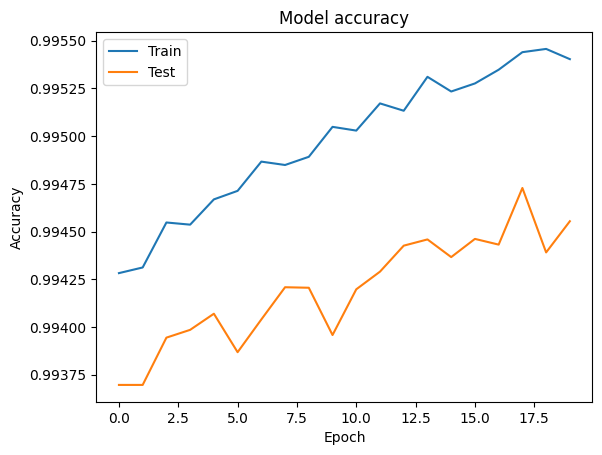

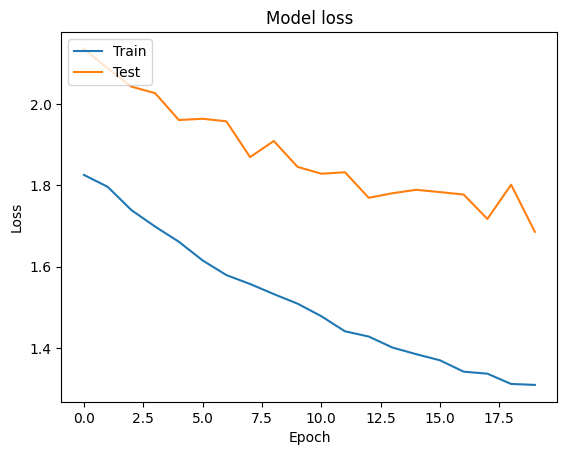

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss_val'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Prediction
pred_cat = model.predict(X_test, verbose=1)
y_te_true = np.argmax(y_test, -1)

108/108 [==============================] - 18s 159ms/step


In [ ]:
#New classification report
from sklearn_crfsuite.utils import flatten
from functools import wraps


def _flattens_y(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        y_true_flat = flatten(y_true)
        y_pred_flat = flatten(y_pred)
        return func(y_true_flat, y_pred_flat, *args, **kwargs)
    return wrapper


@_flattens_y
def flat_classification_report(y_true, y_pred, labels=None, target_names=None, **kwargs):
    """
    Return classification report for sequence items.
    """
    from sklearn import metrics
    return metrics.classification_report(y_true, y_pred, labels=labels, target_names=target_names, **kwargs)

In [ ]:
#Flat Classification report
report = flat_classification_report(y_te_true, pred_cat, target_names=tags)
print(report)

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00    355050
       B-PER       0.90      0.80      0.85       957
      B-MISC       0.85      0.83      0.84       570
       B-ORG       0.84      0.80      0.82      1320
           O       0.98      0.99      0.99     29260
      I-MISC       0.59      0.58      0.58       196
       B-LOC       0.87      0.91      0.89      1443
       I-LOC       0.73      0.72      0.73       236
       I-ORG       0.71      0.68      0.70       737
       I-PER       0.74      0.80      0.77       420

    accuracy                           1.00    390189
   macro avg       0.82      0.81      0.82    390189
weighted avg       1.00      1.00      1.00    390189



In [ ]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_test[i]]))
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if token.index_word.get(w) != 'pad':
        print("{:15}: {:5} {}".format(token.index_word.get(w), idx2tag[t], idx2tag[pred]))

1/1 [==============================] - 0s 175ms/step
Sample number 235 of 3453 (Test Set)
Word           ||True ||Pred
australia      : B-LOC B-LOC
gave           : O     O
brian          : B-PER B-PER
lara           : I-PER I-PER
another        : O     O
reason         : O     O
to             : O     O
be             : O     O
unk            : O     O
when           : O     O
they           : O     O
beat           : O     O
west           : B-LOC B-LOC
indies         : I-LOC I-LOC
by             : O     O
five           : O     O
wickets        : O     O
in             : O     O
the            : O     O
opening        : O     O
world          : B-MISC O
series         : I-MISC O
limited        : O     O
overs          : O     O
match          : O     O
on             : O     O
friday         : O     O
unk            : O     O
